In [1]:
#import modules
from pandas import *
from matplotlib import *
import numpy as np
from CoolProp.CoolProp import PropsSI,Props
from CoolProp.HumidAirProp import HAPropsSI
# import seaborn
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline
options.display.max_columns = 100
# import re

In [2]:
totalData = read_pickle("./totalData.pkl")
#Notneeded!!totalData.columns = list(range(totalData.shape[1]))

In [3]:
totalData = totalData[totalData[2]>0]#removing negative fan flow values
totalData.shape

(40857, 17)

In [4]:
#Preparing the data for the Preheat=0; RelativeHumidity>60%; OAT>52F; Reheat>0; Cool>0
RL_data = totalData[totalData[5]==0]#PreHeat=0
RL_data = RL_data[RL_data[12]>60]#RelativeHumidity>60%
RL_data = RL_data[RL_data[0]>52]#OAT>52F
RL_data = RL_data[RL_data[4]>0]#Reheat>0
RL_data = RL_data[RL_data[3]>0]#Cool>0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f786c15c240>]],
      dtype=object)

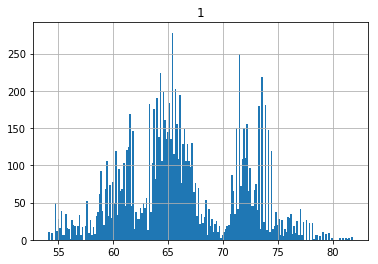

In [5]:
RL_data.hist(column=[1],bins=200)

In [ ]:
#To understand the causes of COOL_OP from ActualTemp and DAT_SPT
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

X_input = DataFrame()
X_input['tempGrad'] = RL_data[0]-RL_data[7]
# X_input[2] = RL_data[2]
# X_input[12] = RL_data[12]
X_input[0] = RL_data[0]
X_input = X_input.to_numpy()
Y_output = RL_data[3].to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.20, shuffle=True)
learner = GBR(n_estimators=1000)
learner.fit(X_train,y_train)
learner.score(X_train,y_train)
#learner.feature_importances_
#learner.score(X_test,y_test) 

from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted = learner.predict(X_test)
1-sqrt(mean_squared_error(y_test, y_predicted))/np.mean(Y_output)

y_predicted = learner.predict(X_train)
1-sqrt(mean_squared_error(y_train, y_predicted))/np.mean(Y_output)
'''Since we cannot change the CCT_SPT let us not worry about it.'''

In [ ]:
'''
0 Index(['Outside Air Temperature.Outside Air Temperature.Trend - Present Value ()',
1       'Discharge Air Temperature.Discharge Air Temperature.Trend - Present Value ()',
2       'Discharge Air Flow.Discharge Air Flow.Trend - Present Value ()',
3       'Chilled Water Valve Ouptut.Chilled Water Valve Ouptut.Trend - Present Value ()',
4       'Reheat Output.Reheat Output.Trend - Present Value ()',
5       'Preheat Output.Preheat Output.Trend - Present Value ()',
6       'PHT_SPT.value',
7       'CCT_SPT.value',
8       'PH_T.value',
9       'PHFBD_O.value',
10       'CC_T.value',
11       'AHU_1.supplyAirTempSetpoint',
12       'AHU_1.outdoorAirHumidity',
13       'DewPoint',
14       'Pressure'],
      dtype='object')
'''
#Units = ['F','F','cfm','%','%','%','F','F','F','%','F','F','%','F','inches']

In [17]:
#To calculate the heating due to the recovery coil
#Preparing the data for the Preheat=0; Reheat=0; Cool>0 ie high temp low humidity
RL_data = totalData[totalData[5]==0]#PreHeat=0
RL_data = RL_data[RL_data[4]==0]#Reheat=0
RL_data = RL_data[RL_data[3]>0]#Cool>0
RL_data = RL_data[RL_data[0]>52]#OAT>52F
#RL_data = RL_data[RL_data[12]>60]#RelativeHumidity>60%




In [18]:
RL_data.shape

(4400, 17)

In [75]:
#Model 3
#See the model for recovery heating after cooling coil
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

Data = DataFrame()

X_input = RL_data[[8,10,2]].to_numpy()

Data['tempGrad'] =  RL_data[1]#-RL_data[10]#DAT/rht_in/ActualTemp - CCT
Y_output = Data.to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.20, shuffle=True)
learner = GBR(n_estimators=2000)
learner.fit(X_train,y_train)
#learner.score(X_train,y_train)
#learner.feature_importances_  
#learner.score(X_test,y_test)

/isis/home/nauga/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
X_train2, X_test2, y_train2, y_test2 = train_test_split( X_input, Y_output, test_size=0.750, shuffle=False)

In [77]:
learner.feature_importances_  #11>1>6>8>10        11>6>|||1>8>10

array([0.29327664, 0.28510289, 0.42162048])

In [78]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted_test = learner.predict(X_test)
1-sqrt(mean_squared_error(y_test, y_predicted_test))/np.mean(np.abs(Y_output))#np.mean(Y_output)

0.9816124080602766

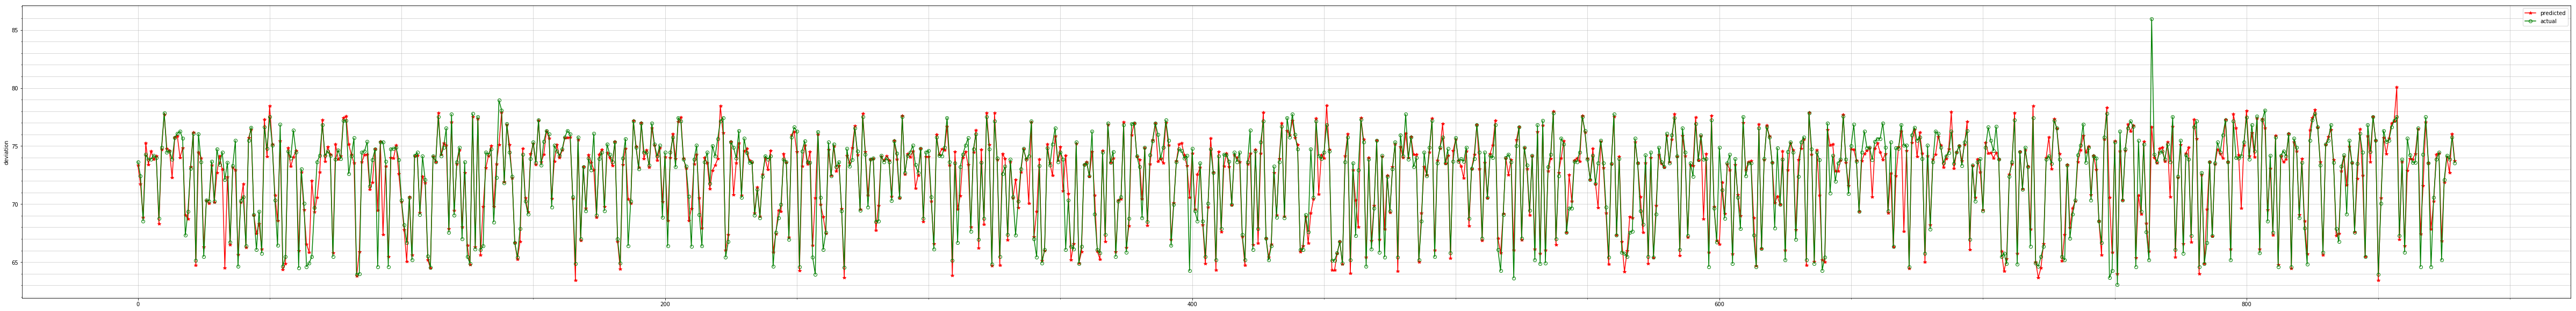

In [79]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [85.0,10.0]
plt.plot(y_predicted_test,'r*-',label='predicted')
plt.plot(y_test,'go-',label='actual',fillstyle='none')
plt.ylabel('deviation')
plt.legend()
plt.grid(which='both',alpha=100)
plt.minorticks_on()
plt.show()

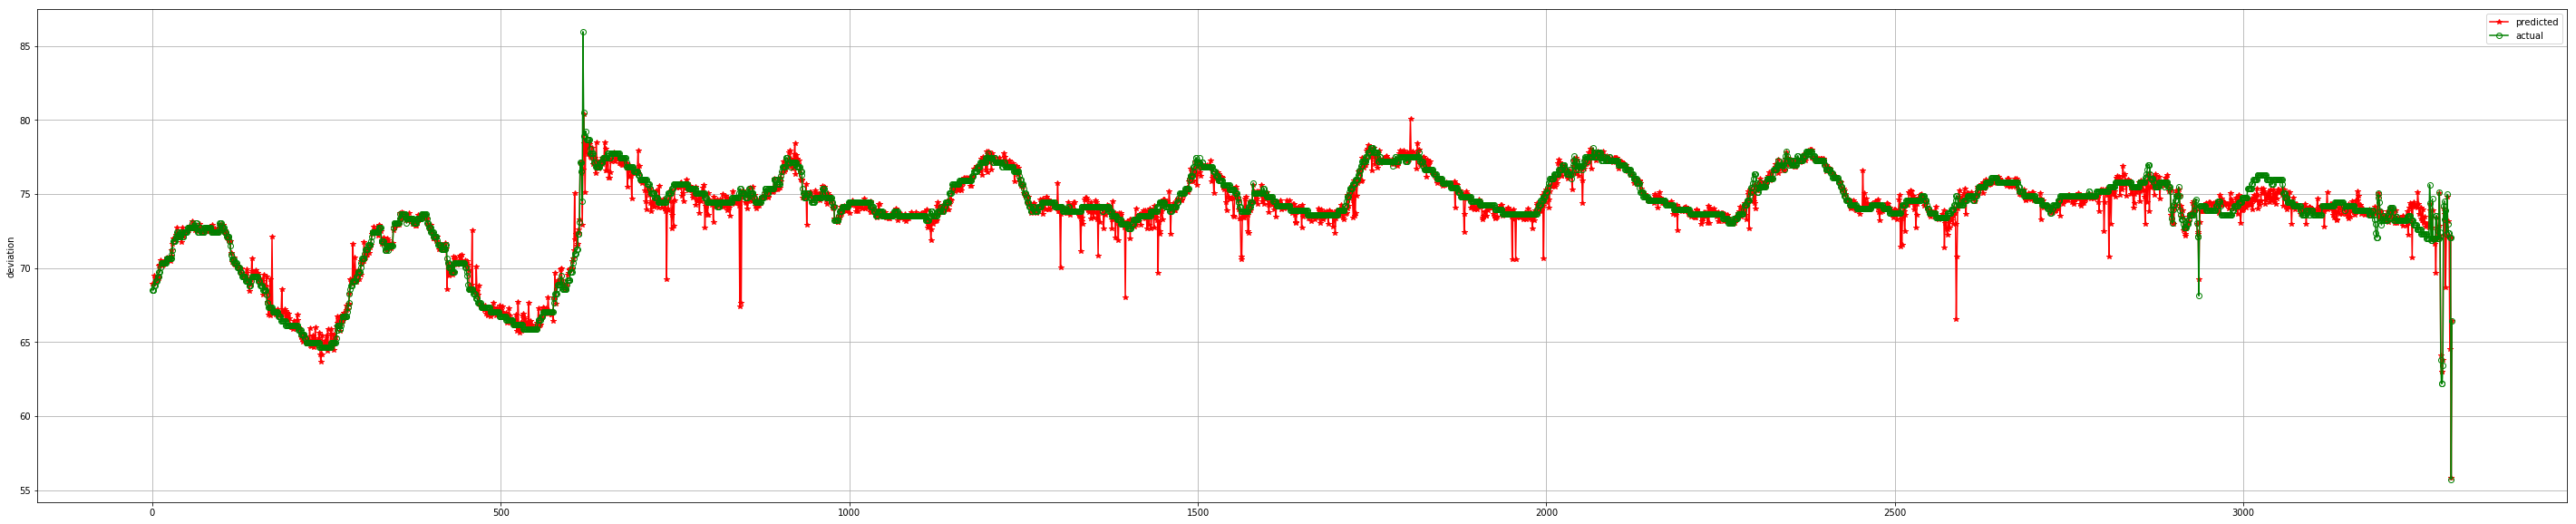

In [82]:
y_predicted_test2 = learner.predict(X_test2)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [50.0,10.0]
plt.plot(y_predicted_test2,'r*-',label='predicted')
plt.plot(y_test2,'go-',label='actual',fillstyle='none')
plt.ylabel('deviation')

plt.legend()
plt.grid()
plt.show()

In [81]:
1-np.mean(np.abs((y_test2 - y_predicted_test2)/y_test2))
#1-sqrt(mean_squared_error(y_test, y_predicted_test))/np.mean(np.abs(Y_output))

0.960588790087066

In [ ]:
y_predicted = learner.predict(X_train)
1-sqrt(mean_squared_error(y_train, y_predicted))/np.mean(np.abs(Y_output))#np.mean(Y_output)

In [ ]:
#Preparing the data for the PReheat=0; RelativeHumidity>60%; OAT>52F; Reheat>0; Cool>0
RL_data = totalData[totalData[5]==0]#PreHeat=0
RL_data = RL_data[RL_data[12]>60]#RelativeHumidity>60%
RL_data = RL_data[RL_data[0]>52]#OAT>52F
RL_data = RL_data[RL_data[4]>0]#Reheat>0
RL_data = RL_data[RL_data[3]>0]#Cool>0

In [ ]:
RL_data.shape

In [ ]:
# Now we model the Reheat Output:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

Data = DataFrame()
Data['tempErr'] =  RL_data[11]-RL_data[1]#diff between r_t-1 = DAT_SPT and y_t-1 = DAT
Data[10] = RL_data[10]
X_input = Data.to_numpy()

Y_output = RL_data[4].to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.30, shuffle=True)
learner = GBR(n_estimators=1000)
learner.fit(X_train,y_train)
#learner.score(X_train,y_train)
#learner.feature_importances_  
#learner.score(X_test,y_test)

In [ ]:
learner.feature_importances_

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted_test = learner.predict(X_test)
1-sqrt(mean_squared_error(y_test, y_predicted_test))/np.mean(Y_output)

In [ ]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [85.0,10.0]
plt.plot(y_predicted_test[1000:1500],'r*-',label='predicted')
plt.plot(y_test[1000:1500],'go-',label='actual',fillstyle='none')
plt.ylabel('deviation')
plt.legend()
plt.grid(which='both',alpha=100)
plt.minorticks_on()
plt.show()

In [ ]:
y_predicted = learner.predict(X_train)
1-sqrt(mean_squared_error(y_train, y_predicted))/np.mean(Y_output)

In [4]:
#Model 5 or DAT
#Preparing the data for the pReheat=0; RelativeHumidity>60%; OAT>52F; Reheat>0; Cool>0
RL_data = totalData[totalData[5]==0]#PreHeat=0
RL_data = RL_data[RL_data[12]>60]#RelativeHumidity>60%
RL_data = RL_data[RL_data[0]>52]#OAT>52F
RL_data = RL_data[RL_data[4]>0]#Reheat>0
RL_data = RL_data[RL_data[3]>0]#Cool>0

In [5]:
#Saving model3 so that it can be used to generate data for model 5
from joblib import dump, load
#dump(learner, 'HeatRecov2.joblib')
heatRecov = load('HeatRecov2.joblib')

#Creating the predictor
def predictor(x1,x2,x3):
    delta = heatRecov.predict(np.array([[x1,x2,x3]]))
    return delta[0]

#RL_data['temp1'] = RL_data.apply(lambda x: predictor(x[2],x[8]) , axis=1)

In [6]:
RL_data['temp1'] = RL_data.apply(lambda x: predictor(x[1],x[8],x[10]) , axis=1)
RL_data['temp1'] = RL_data['temp1'].shift(1)
RL_data.dropna(axis=0,how='any',inplace=True)#Now we drop rows with NaN values

In [7]:
RL_data.shape

(10709, 18)

In [ ]:
#Now we model the DAT:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

RL_data['temp2'] = RL_data[10]+RL_data['temp1']
Data = DataFrame()
X_input = RL_data[[1,4,10,'temp2',8]].to_numpy()#[[4,10,'temp2']]
#including temp2 is okay because you do not have to worry about exploring and it will
#always lie within certain bounds if you do not explore with CC coils stp too much
#Also DAT is well distributed iver a range fr this data
Data['tempGrad'] =  RL_data[1]-RL_data['temp2']#RL_data[10]-RL_data['temp1']#diff between y_t-1 = DAT and delta+cc_t
Y_output = Data.to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.350, shuffle=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split( X_input, Y_output, test_size=0.750, shuffle=False)
learner = GBR(n_estimators=1000,)#criterion='mae')
learner.fit(X_train,y_train)
#learner.score(X_train,y_train)
#learner.feature_importances_
#learner.score(X_test,y_test)

In [8]:
#Now we model the DAT:#ALTERNATE MODEL
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

RL_data['temp2'] = RL_data[10]+RL_data['temp1']
Data = DataFrame()
X_input = RL_data[[4,10]].to_numpy()#[[4,10,'temp2']]

Data['tempGrad2'] =  RL_data[1]-RL_data['temp2']#-RL_data[10]-RL_data['temp1']#diff between y_t-1 = DAT and delta+cc_t
Y_output = Data['tempGrad2'].to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.350, shuffle=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split( X_input, Y_output, test_size=0.050, shuffle=False)
learner = GBR(n_estimators=1000,)#criterion='mae')
learner.fit(X_train,y_train)
#learner.score(X_train,y_train)
#learner.feature_importances_
#learner.score(X_test,y_test)v

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
learner.feature_importances_   #1>10>8>temp2>temp1
#RL_data.columns

array([0.28817746, 0.71182254])

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted_test = learner.predict(X_test)
1-sqrt(mean_squared_error(y_test, y_predicted_test))/sqrt(np.mean(np.square(Y_output)))

0.4088816496680976

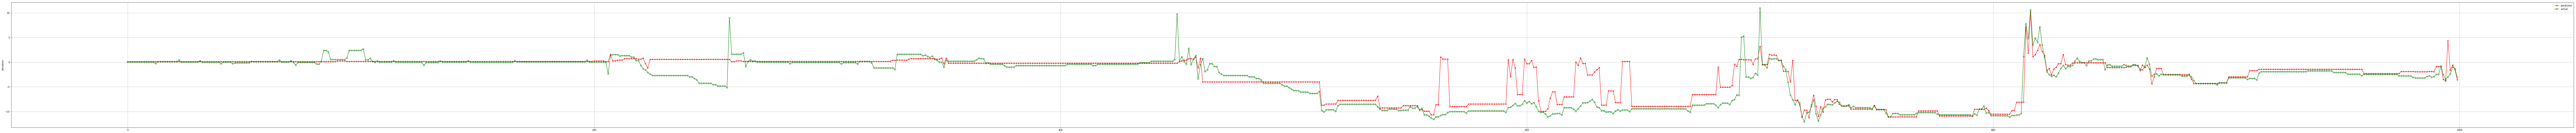

In [11]:
import matplotlib
y_predicted_test2 = learner.predict(X_test2)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [200.0,10.0]
plt.plot(y_predicted_test2[5000:6000],'r*-',label='predicted')
plt.plot(y_test2[5000:6000],'go-',label='actual',fillstyle='none')
#plt.plot(RL_data['temp2'].to_numpy()[5000:6000],'k3-',label='RHT_OP')
plt.ylabel('deviation')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [200.0,10.0]
plt.plot(y_predicted_test[1:1000],'r*-',label='predicted')
plt.plot(y_test[1:1000],'go-',label='actual',fillstyle='none')
plt.ylabel('deviation')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y = np.subtract(y_predicted_test,y_test)#np.abs(np.subtract(y_predicted_test,y_test))

In [ ]:
y_predicted_test.shape
type(y_predicted_test)
y_predicted_test

In [ ]:
1-np.mean(np.abs((y_test - y_predicted)/y_test))

In [ ]:
y_predicted_train = learner.predict(X_train)
1-sqrt(mean_squared_error(y_train, y_predicted_train))/np.mean(np.abs(Y_output))

In [ ]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [35.0,10.0]
plt.plot(y_predicted_train[0:500],'r*-',label='predicted')
plt.plot(y_train[0:500],'k3-',label='actual')
plt.ylabel('deviation')
plt.legend()
plt.show()

In [ ]:
1-np.mean(np.abs((y_train - y_predicted)/y_train))

In [ ]:
learner.score(X_train,y_train)
#learner.score(X_test,y_test)
learner.feature_importances_

In [ ]:
#Seeing hist plots of the reheat output for the period considered
RL_data.hist(column=['temp2'],bins=40)

In [ ]:
#Right now the DAT is independent of the DAT_SPT and RHT_OP. Why? Because the variation in reheat output is so low 0 or 100%
#But during RL based exploration, we can allow the controller to manipulate DAT_SPT in such a way that
#intermediate values of the rht_opt are fed to the controller. but then again how are we going to adjust ofr its feature importance
#in DAT model? 

In [ ]:
#Reading the different Excel Sheets containing different Data Columns
df1 = read_excel('AlumniHallData.xlsx',sheet_name="Sheet1")
#sample type 1 date='11/4/18 1:00:00 AM CDT'
#sample type 2 date='11/4/18 2:00:00 AM CST'


In [ ]:
df1.head()

In [ ]:
df1.columns

In [ ]:
df1.columns = [0,1,2,3,4,5,6]

In [ ]:
#Model 3
#See the model for recovery heating after cooling coil
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

Data = DataFrame()

X_input = df1[[3,4,5,6]].to_numpy()

Data['tempGrad'] =  df1[1]+df1[2]#DAT/rht_in/ActualTemp - CCT
Y_output = Data.to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.25, shuffle=True)
learner = GBR(n_estimators=3000)
learner.fit(X_train,y_train)
#learner.score(X_train,y_train)
#learner.feature_importances_  
#learner.score(X_test,y_test)

In [ ]:
from pandas import *
from matplotlib import *
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
Class_HC_SVR = load('Class_HC_SVR.joblib')

In [ ]:
df1 = read_excel('AlumniHallData.xlsx',sheet_name="Sheet1")
df1.columns = [0,1,2,3,4,5,6]
Data = DataFrame()
X_input = df1[[3,4,5,6]].to_numpy()
Data['tempGrad'] =  df1[1]+df1[2]#DAT/rht_in/ActualTemp - CCT
Y_output = Data.to_numpy()

In [ ]:
y_predicted_test = Class_HC_SVR.predict(X_input)

In [ ]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [50.0,20.0]
fig = plt.figure()
plt.plot(Y_output,'go-',label='actual',fillstyle='none')
plt.plot(y_predicted_test,'r*-',label='predicted')
plt.ylabel('deviation')
plt.legend()
plt.grid()
plt.show()
fig.savefig('ClusteredSimulation.png')

In [4]:
'''Doing the preheat temperature to cooling coil heat recovery loop modeling'''

'Doing the preheat temperature to cooling coil heat recovery loop modeling'

In [4]:
totalData[0] = totalData[0].astype(np.float)

In [5]:
#Preparing the data for the Preheat>0; OAT<52F; Reheat=0; Cool=0
RL_data = totalData[totalData[5]>0]#PreHeat>0
#RL_data = RL_data[RL_data[12]>60]#RelativeHumidity>60%
RL_data = RL_data[RL_data[0]<52]#OAT<52F
RL_data = RL_data[RL_data[4]==0]#Reheat>0
RL_data = RL_data[RL_data[3]==0]#Cool>0


In [6]:
RL_data.shape

(15884, 17)

In [7]:
RL_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,PH_T_energy,Cooling_energy
count,15884.000000,15884.000000,15884.000000,15884.0,15884.0,15884.000000,15884.000000,15884.0,15884.000000,15884.000000,15884.000000,15884.0,15884.000000,15884.000000,15884.000000,15884.000000,15884.0
mean,40.776166,74.125447,2375.229700,0.0,0.0,76.478521,70.135042,53.0,70.004967,81.480764,70.355964,73.0,69.361476,34.102990,30.200451,187.667858,0.0
std,6.965870,5.091311,275.564719,0.0,0.0,26.431732,0.622023,0.0,1.714271,18.885096,2.507994,0.0,15.415144,7.790162,0.129991,52.835409,0.0
min,-12.982890,52.146210,1553.792000,0.0,0.0,0.209253,70.000000,53.0,52.251343,0.000000,52.577374,73.0,26.683138,12.900000,29.590000,0.000000,0.0
25%,36.343313,72.080602,2210.553250,0.0,0.0,47.838620,70.000000,53.0,69.404350,67.001404,69.997528,73.0,60.000000,28.900000,30.140000,158.739250,0.0
50%,41.616310,72.776860,2239.030000,0.0,0.0,100.000000,70.000000,53.0,70.022430,76.683846,70.677677,73.0,71.000000,39.000000,30.230000,181.761242,0.0
75%,46.430900,73.631988,2436.282000,0.0,0.0,100.000000,70.000000,53.0,70.667969,100.000000,71.244766,73.0,82.000000,39.000000,30.240000,207.722173,0.0
max,51.992180,96.025630,4001.022000,0.0,0.0,100.000000,73.000000,53.0,92.335808,100.000000,84.247932,73.0,93.000000,68.000000,30.490000,484.451333,0.0


In [13]:
#Now we model the post-preheat to precool section
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split

Data = DataFrame()
Data['tempGrad1'] =  RL_data[8] - RL_data[10]
Data[8] = RL_data[8]
#Data[5] = RL_data[5]
Data[2] = RL_data[2]
X_input = Data[[8,2]].to_numpy()
#X_input = RL_data[[0,8,10]].to_numpy()#[[4,10,'temp2']]


Data['tempGrad2'] =  RL_data[10]#RL_data[8]-RL_data[10]
Y_output = Data['tempGrad2'].to_numpy()

X_input = X_input[:-1]
Y_output = Y_output[1:]

X_train, X_test, y_train, y_test = train_test_split( X_input, Y_output, test_size=0.350, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split( X_input, Y_output, test_size=0.050, shuffle=False)
learner = GBR(n_estimators=1000,)#criterion='mae')
learner.fit(X_train,y_train)
#learner.score(X_train,y_train)
learner.feature_importances_
#learner.score(X_test,y_test)v

array([0.97402593, 0.02597407])

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted_test = learner.predict(X_test)
1-sqrt(mean_squared_error(y_test, y_predicted_test))/sqrt(np.mean(np.square(Y_output)))

0.9884553359174981

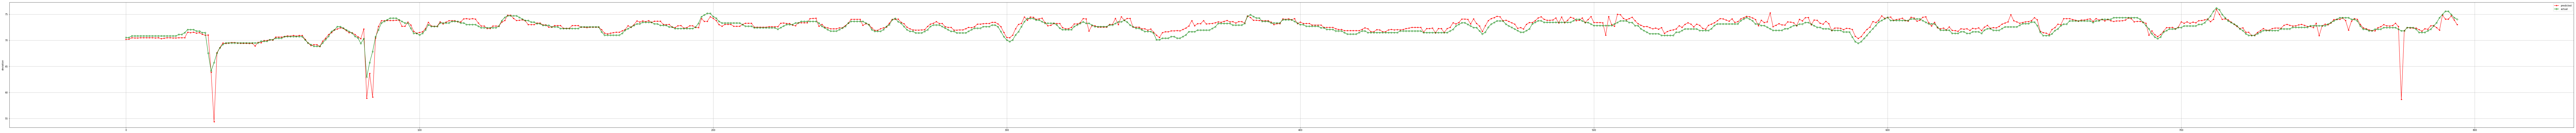

In [15]:
import matplotlib
y_predicted_test2 = learner.predict(X_test2)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [200.0,10.0]
plt.plot(y_predicted_test2,'r*-',label='predicted')
plt.plot(y_test2,'go-',label='actual',fillstyle='none')
#plt.plot(RL_data['temp2'].to_numpy()[5000:6000],'k3-',label='RHT_OP')
plt.ylabel('deviation')
plt.legend()
plt.grid()
plt.show()

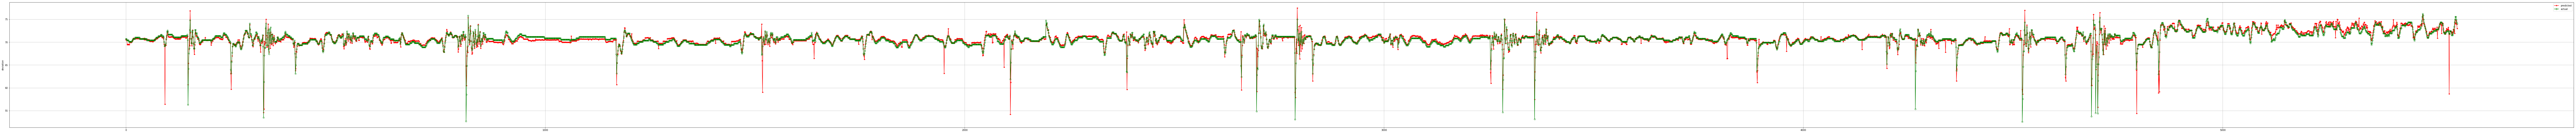

In [16]:
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [200.0,10.0]
plt.plot(y_predicted_test,'r*-',label='predicted')
plt.plot(y_test,'go-',label='actual',fillstyle='none')
plt.ylabel('deviation')
plt.legend()
plt.grid()
plt.show()